In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai as fai
import fastai.vision as fv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import numpy as np
from pathlib import Path
import random
import gc

from torch.utils.data import Dataset
from torchvision import transforms, utils

import PIL

In [3]:
path = Path('crop_part1')

In [4]:
def is_listy(x):
    return isinstance(x, (list,tuple))

class AgeSexItem(fv.ItemBase):
    def __init__(self,array):
        self.data = np.array(array).astype(np.float32)
    
    def __str__(self):
        L = ["Male","Female"]
        return str(self.data[0]) + " / " + L[int(self.data[1] > 0.5)]

class AgeSexList(fv.ItemList):
    def __init__(self, items:fv.Iterator, **kwargs):
        super().__init__(np.array(items, dtype=np.float32), **kwargs)
        
        
        self.c = items.shape[1]
    
    def get(self,i):
        o = super().get(i)
        return AgeSexItem(o)
    
    def reconstruct(self,t):
        if is_listy(t):
            return AgeSexItem(np.array(t))
        return AgeSexItem(t.numpy())

In [5]:
def extract_age_sex(filename):
    f=filename.stem.split("_")
    return float(f[0]), float(f[1])

In [6]:
def load_face_data(img_size, batch_size, amount=1.):
    tfms = fv.get_transforms(max_warp=0.)
    return (fv.ImageItemList.from_folder(path)
           .filter_by_rand(amount,seed=13)
           .random_split_by_pct(0.1,seed=13)
           .label_from_func(extract_age_sex,label_cls=AgeSexList)
           .transform(tfms, size=img_size)
           .databunch(bs=batch_size))

In [7]:
data = load_face_data(192,64,amount=0.2)

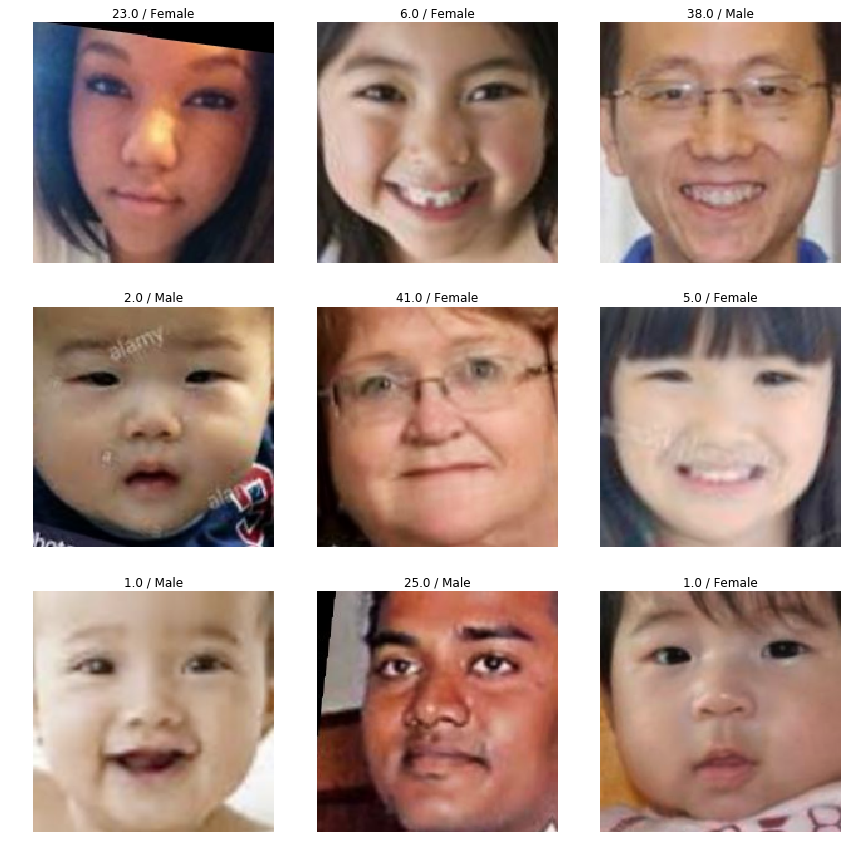

In [8]:
data.show_batch(rows=3,seed=13)

In [9]:
def age_sex_loss(pred,targ):
    a = 0.3
    bias = torch.FloatTensor([0.,5.]).cuda()
    scale = torch.FloatTensor([1.,10.]).cuda()
    p = pred.mul(scale)
    t = targ.mul(scale)
    p.add_(bias)
    t.add_(bias)
    p = (1+pred)**a
    t = (1+targ)**a
    return F.mse_loss(p,t)

In [10]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.squeeze()

def num_params(model):
    total=0
    for p in list(model.parameters()):
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [11]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
#        self.layer2 = nn.Sequential(
#            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(16),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2))
#        self.layer3 = nn.Sequential(
#            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(32),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.adaptivePool = fai.layers.AdaptiveConcatPool2d()
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
#        out = self.layer2(out)
#        out = self.layer3(out)
        out = self.layer4(out)
        out = self.adaptivePool(out)
        out = out.reshape(out.size(0), -1)
        self.out = out
        out = self.fc1(out)
        out = self.fc2(out)
        return out
model = Net()
#model
num_params(model)

58082

In [13]:
gc.collect()

0

In [14]:
learner = fai.basic_train.Learner(data, model, loss_func=F.mse_loss, wd=0.1)

In [15]:
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 1.96 GiB total capacity; 1.54 GiB already allocated; 1.69 MiB free; 24.40 MiB cached)

In [ ]:
learner.fit_one_cycle(5)

In [ ]:
fdaf

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(4,1e-3)

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(4,1e-4)

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle()

In [ ]:
learner.show_results(rows=3)